In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
data = pd.read_csv('train_data.csv')
data = data.values

X = data[:, 0]
Y = data[:, 1]

X = np.array([np.array([ord(c) - ord('a') + 1 for c in s]) for s in X])
Y = np.array([np.array([ord(c) - ord('a') + 1 for c in s]) for s in Y])
Y = np.array([np.append([0], y) for y in Y])

# Load Test data
test_data = pd.read_csv('eval_data.csv')
test_data = test_data.values

X_test = test_data[:,0]
Y_test = test_data[:,1]

X_test = np.array([np.array([ord(c) - ord('a') + 1 for c in s]) for s in X_test])
Y_test = np.array([np.array([ord(c) - ord('a') + 1 for c in s]) for s in Y_test])
Y_test = np.array([np.append([0], y) for y in Y_test])

# convert to torch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

print(X.shape, Y.shape, X_test.shape, Y_test.shape)

torch.Size([7000, 8]) torch.Size([7000, 9]) torch.Size([2000, 8]) torch.Size([2000, 9])


In [3]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=7000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).view(-1,1)  
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x: torch.tensor)->torch.tensor:
        return self.dropout(x + self.pe[:x.size(0), :])

In [4]:
class TransformerModel(nn.Module):
    def __init__(self, n_tokens, d_model, n_heads, n_encoder_layers, n_decoder_layers, dropout):
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model
        # layers
        self.embedding = nn.Embedding(n_tokens, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer = nn.Transformer(d_model, n_heads, n_encoder_layers, n_decoder_layers, dropout=dropout, batch_first=True,activation='relu',dim_feedforward=300)
        self.decoder = nn.Linear(d_model, n_tokens)

    def forward(self, src, tgt):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        tgt = self.embedding(tgt)
        tgt = self.pos_encoder(tgt)
        output = self.transformer(src, tgt)
        output = self.decoder(output)
        return output

    def predict(model,input_str):
        model.eval()
        output = ''
        input_str = np.array([np.array([ord(c) - ord('a') + 1 for c in input_str])])
        src = torch.tensor(input_str)
        tgt = torch.tensor([[0]])
        for _ in range(8):
            pred = model(src, tgt)
            pred = pred.argmax(dim=2)
            output += chr(pred[0, -1] + ord('a') - 1)
            tgt = torch.cat((tgt, pred[:, -1].unsqueeze(0)), dim=1)
        return output
        

In [5]:
# Hyperparameters
n_tokens = 27
d_model = 300
n_heads = 2
n_encoder_layers = 2
n_decoder_layers = 2
dropout = 0.1
batch_size = 10
epochs = 300
lr = 0.0001

# model
model = TransformerModel(n_tokens, d_model, n_heads, n_encoder_layers, n_decoder_layers, dropout)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer-adam
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch: 1/300 Loss: 2.6651395991870337
Epoch: 2/300 Loss: 2.338767604827881
Epoch: 3/300 Loss: 2.2865554441724503
Epoch: 4/300 Loss: 2.2514947390556337
Epoch: 5/300 Loss: 2.2201537018162862
Epoch: 6/300 Loss: 2.1900468025888715
Epoch: 7/300 Loss: 2.16590321625982
Epoch: 8/300 Loss: 2.1424389910697936
Epoch: 9/300 Loss: 2.124308226960046
Epoch: 10/300 Loss: 2.1055176637853896
Epoch: 11/300 Loss: 2.091756434610912
Epoch: 12/300 Loss: 2.0764838823250362
Epoch: 13/300 Loss: 2.0574706622532437
Epoch: 14/300 Loss: 2.042976622581482
Epoch: 15/300 Loss: 2.035529725211007
Epoch: 16/300 Loss: 2.021681806359972
Epoch: 17/300 Loss: 2.0029923100130897
Epoch: 18/300 Loss: 1.9868180899960655
Epoch: 19/300 Loss: 1.9789521309307643
Epoch: 20/300 Loss: 1.965154003075191
Epoch: 21/300 Loss: 1.9516331100463866
Epoch: 22/300 Loss: 1.9346711548737117
Epoch: 23/300 Loss: 1.93322643331119
Epoch: 24/300 Loss: 1.9134165138857706
Epoch: 25/300 Loss: 1.9019621457372393
Epoch: 26/300 Loss: 1.8915874358585902
Epoch:

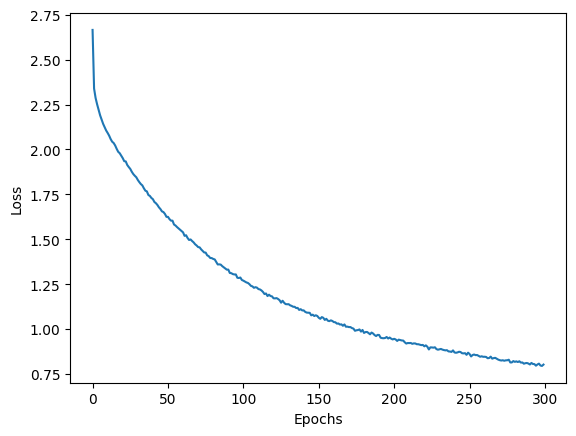

In [6]:
def train(model, X, Y, criterion, optimizer, epochs, batch_size):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for i in range(0, len(X), batch_size):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            optimizer.zero_grad()
            output = model(x, y[:, :-1])
            output1 = output.permute(0, 2, 1) 
            loss = criterion(output1, y[:, 1:])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # loss over all batches
        n_batches = len(X) // batch_size
        losses.append(total_loss / n_batches)
        print(f'Epoch: {epoch+1}/{epochs} Loss: {total_loss / n_batches}')
    # plot loss per epoch
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show() 
    return losses, model

losses, model = train(model, X, Y, criterion, optimizer, epochs, batch_size)

In [8]:
def predict(model,input_str):
    model.eval()
    output = ''
    input_str = np.array([np.array([ord(c) - ord('a') + 1 for c in input_str])])
    src = torch.tensor(input_str)
    tgt = torch.tensor([[0]])
    for _ in range(8):
        pred = model(src, tgt)
        pred = pred.argmax(dim=2)
        output += chr(pred[0, -1] + ord('a') - 1)
        tgt = torch.cat((tgt, pred[:, -1].unsqueeze(0)), dim=1)
    return output

In [10]:
# Function to check how many characters match in the two strings
def check(pred: str, true: str):
    correct = 0
    for a, b in zip(pred, true):
        if a == b:
            correct += 1
    return correct

# Function to score the model's performance
def evaluate(model):
    print("Obtaining metrics for eval data:")
    eval_data = pd.read_csv("eval_data.csv").to_numpy()
    results = {
        "pred": [],
        "true": [],
        "score": [],
    }
    correct = [0 for _ in range(9)]
    for x, y in eval_data:
        pred = predict(model, x)
        score = check(pred, y)
        results["pred"].append(pred)
        results["true"].append(y)
        results["score"].append(score)

        correct[score] += 1
    print("Eval dataset results:")
    for num_chr in range(9):
        print(
            f"Number of predictions with {num_chr} correct predictions: {correct[num_chr]}"
        )
    points = sum(correct[4:6]) * 0.5 + sum(correct[6:])
    marks = round(min(2, points / 1400 * 2) * 2) / 2  # Rounds to the nearest 0.5
    print(f"Points: {points}")
    print(f"Marks: {marks}")
    # Save predicitons and true sentences to inspect manually if required.
    pd.DataFrame.from_dict(results).to_csv("results_eval.csv", index=False)


evaluate(model)


Obtaining metrics for eval data:


Eval dataset results:
Number of predictions with 0 correct predictions: 1349
Number of predictions with 1 correct predictions: 556
Number of predictions with 2 correct predictions: 86
Number of predictions with 3 correct predictions: 9
Number of predictions with 4 correct predictions: 0
Number of predictions with 5 correct predictions: 0
Number of predictions with 6 correct predictions: 0
Number of predictions with 7 correct predictions: 0
Number of predictions with 8 correct predictions: 0
Points: 0.0
Marks: 0.0


In [11]:
# saving model
torch.save(model, 'model.pth')